Я буду сразу реализовывать задачу в терминах ООП

In [350]:
import pandas as pd
import requests
from requests.exceptions import ReadTimeout
import seaborn as sns
import matplotlib.pyplot as plt
from random import choice

In [4]:
class NoDataException(Exception):
    pass

In [5]:
class APIClient:

    @staticmethod
    def make_request(url, method, *args, **kwargs):
        response = getattr(requests, method)(url, *args, **kwargs)

        if not response.ok:
            raise ValueError

        if data := response.json():
            return data

        raise NoDataException


In [355]:
class OurHomeService:
    __data_url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset}&limit={limit}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'

    __detail_data_url = "https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{uid}"

    __client = APIClient()

    def __get_url(self, offset, limit):
        return self.__data_url.format(offset=offset,limit=limit)

    def __get_detail_url(self, uid):
        return self.__detail_data_url.format(uid=uid)

    @staticmethod
    def __get_list_data(response):
        return response.json().get("data").get("list")

    def __extract_obj_ids(self, limit):
        offset = 0
        res = set()

        print("Extracting objects")

        while True:
            url = self.__get_url(offset, limit)
            try:
                data = self.__client.make_request(url, "get").get("data").get("list")
            except ValueError:
                continue
            except NoDataException:
                break

            if not data:
                break

            res.update(list(map(lambda item: item.get("objId"), data)))
            offset += limit

            print(f"Objects extracted: {len(res)}")

        return res

    def get_detail_data(self, limit):
        ids = self.__extract_obj_ids(limit)

        res = []

        print("Getting detail data")

        for uid in ids:
            url = self.__get_detail_url(uid)
            try:
                data = self.__client.make_request(url, "get", timeout=10)
            except (ValueError, NoDataException, ReadTimeout):
                continue
            except Exception:
                return res
            else:
                if not len(res) % 100:
                    print(f"Detail objects got: {len(res)}")

                res.append(data.get("data"))

        return res

In [388]:
class Task:
    service = OurHomeService()

    @staticmethod
    def __filter_data(df):
        include_columns = [
            "region",
            "floorMax",
            "objElemLivingCnt",
            "objReady100PercDt",
            "objSquareLiving",
            "objElemParkingCnt",
            "objPriceAvg"
        ]

        return df[include_columns]

    def __prepare_data(self, df):
        df = self.__filter_data(df)

        df["objReady100PercDt"] = pd.to_datetime(df["objReady100PercDt"], format="%Y-%m-%d")

        return df


    def get_detail_data(self, limit):
        data = self.service.get_detail_data(limit)

        df = pd.DataFrame(data=pd.json_normalize(data, max_level=0))
        return self.__prepare_data(df)

    @staticmethod
    def plot_index_per_square_by_region(df, column, title):
        df = df[["region", column]].dropna().groupby("region").mean().sort_values([column], ascending=True)

        sns.set(font_scale=1.7)
        plt.figure(figsize=(30,20))

        df["region"] = df.index

        bar = sns.barplot(x="region", y=column, data=df, order=df.region)

        bar.set_xlabel("Регион", fontsize=20)
        bar.set_ylabel(column, fontsize=20)
        bar.set_title(title)

        return df

    @staticmethod
    def get_volume_commissioned_housing(df):
        df = (
            df[["region", "objReady100PercDt"]]
            .dropna()
            .groupby([df.region, df.objReady100PercDt.dt.year])
            .size()
            .unstack()
            .fillna("-")
        )

        print(df.head(len(df)))

        return df

    @staticmethod
    def box_plot(df, column, title):
        df = df[["region", column]].dropna()
        sns.set(font_scale=1.7)

        cat = sns.catplot(x="region", y=column, data=df, kind="box", height=15, aspect=2)

        cat.fig.suptitle(title, fontsize=24, fontdict={"weight": "bold"})

    @staticmethod
    def corr_plot(df, num=3):
        sns.set_theme(style="ticks")

        region_set = list(set(df["region"]))

        selected_regions = list()

        for _ in range(num):
            region = choice(region_set)
            region_set.remove(region)
            selected_regions.append(region)

        df = df[df.region.isin(selected_regions)]

        sns.pairplot(df, hue="region", plot_kws={"s": 10})

In [389]:
task = Task()

In [358]:
detail_data = task.get_detail_data(1000)

Extracting objects
Objects extracted: 1000
Objects extracted: 2000
Objects extracted: 3000
Objects extracted: 4000
Objects extracted: 5000
Objects extracted: 6000
Objects extracted: 7000
Objects extracted: 8000
Objects extracted: 9000
Objects extracted: 10000
Objects extracted: 10535
Getting detail data
Detail objects got: 0
Detail objects got: 100
Detail objects got: 200
Detail objects got: 300
Detail objects got: 400
Detail objects got: 500
Detail objects got: 600
Detail objects got: 700
Detail objects got: 800
Detail objects got: 900
Detail objects got: 1000
Detail objects got: 1100
Detail objects got: 1200
Detail objects got: 1300
Detail objects got: 1400
Detail objects got: 1500
Detail objects got: 1600
Detail objects got: 1700
Detail objects got: 1800
Detail objects got: 1900


/var/folders/1f/8c9wkmd10438byjmxm_49p0h5s1j7k/T/ipykernel_28394/1422708435.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["objReady100PercDt"] = pd.to_datetime(df["objReady100PercDt"], format="%Y-%m-%d")


floorMax  region
region                   
51       3.000000      51
44       3.600000      44
8        4.000000       8
89       7.000000      89
65       7.333333      65
...           ...     ...
25      20.425000      25
66      20.954545      66
2       21.087719       2
20      22.000000      20
48      22.000000      48

[72 rows x 2 columns]

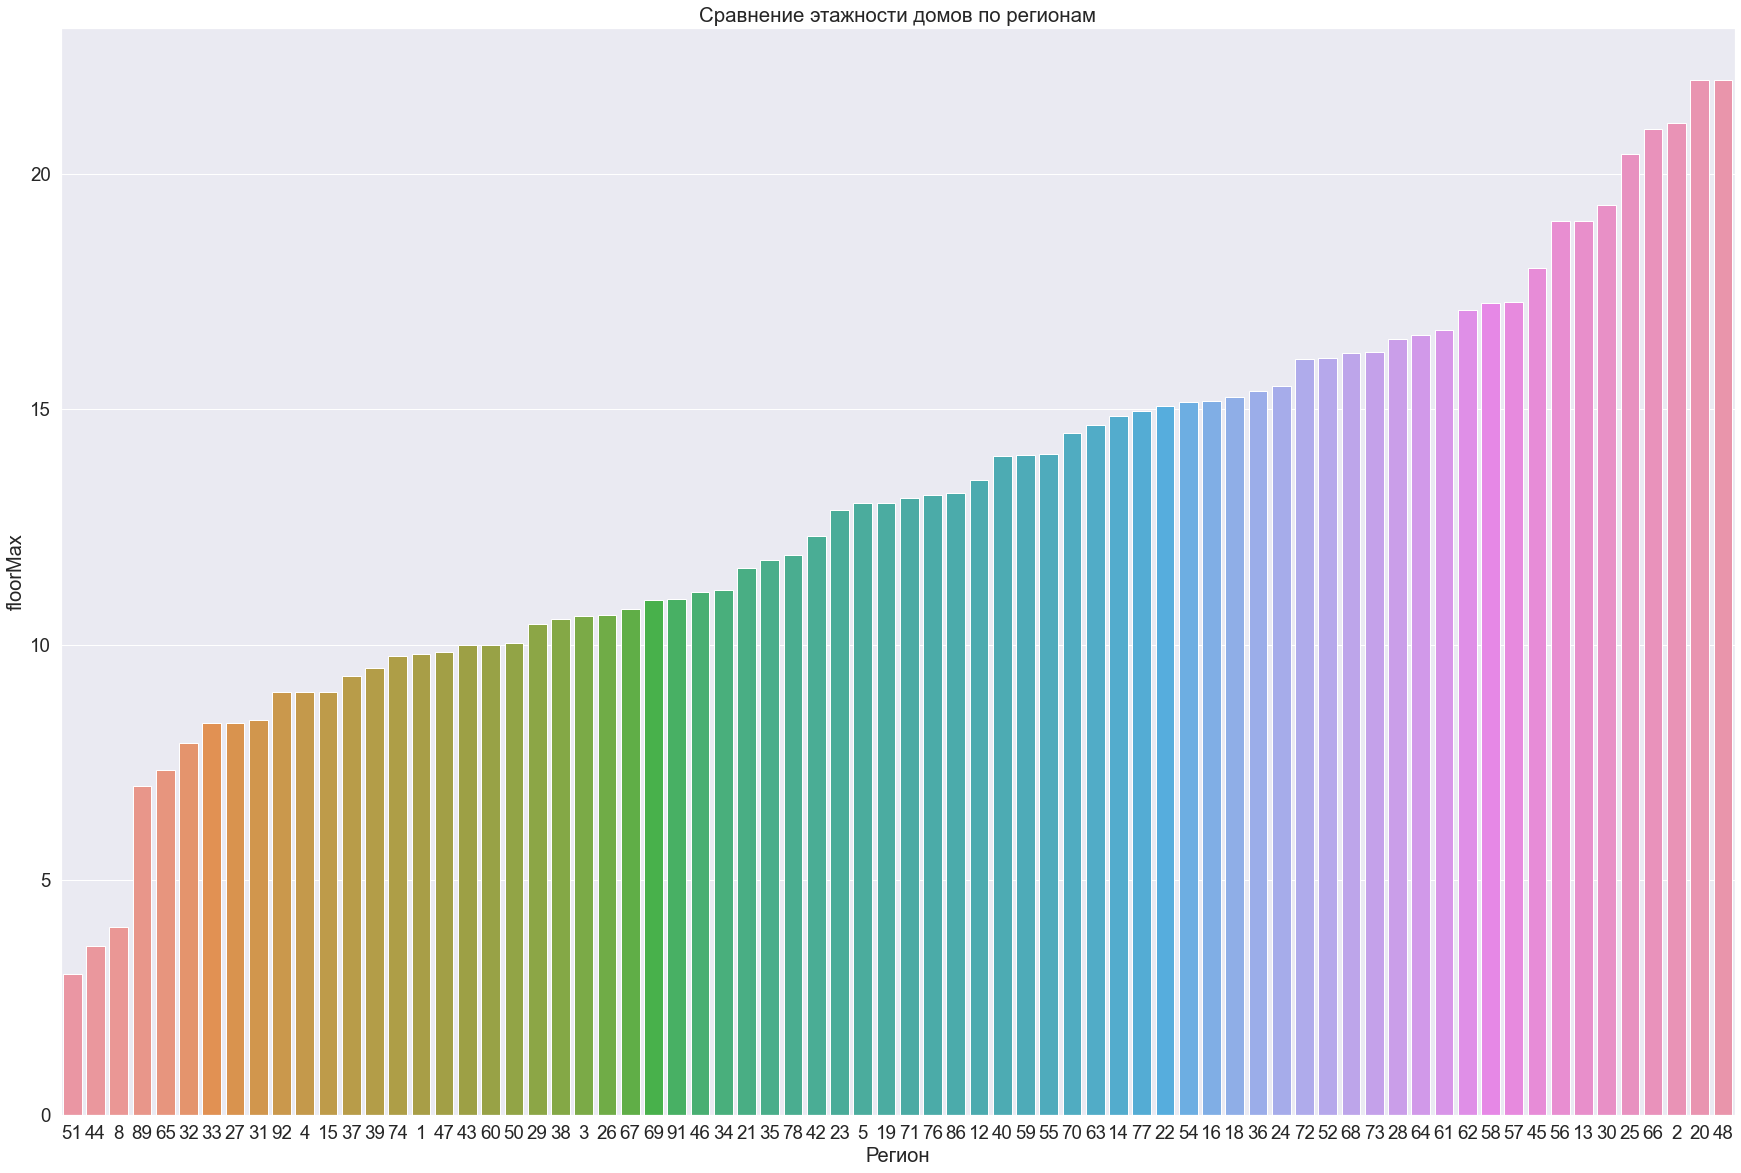

In [365]:
# Сравнение этажности домов по регионам
task.plot_index_per_square_by_region(detail_data, "floorMax", "Сравнение этажности домов по регионам")

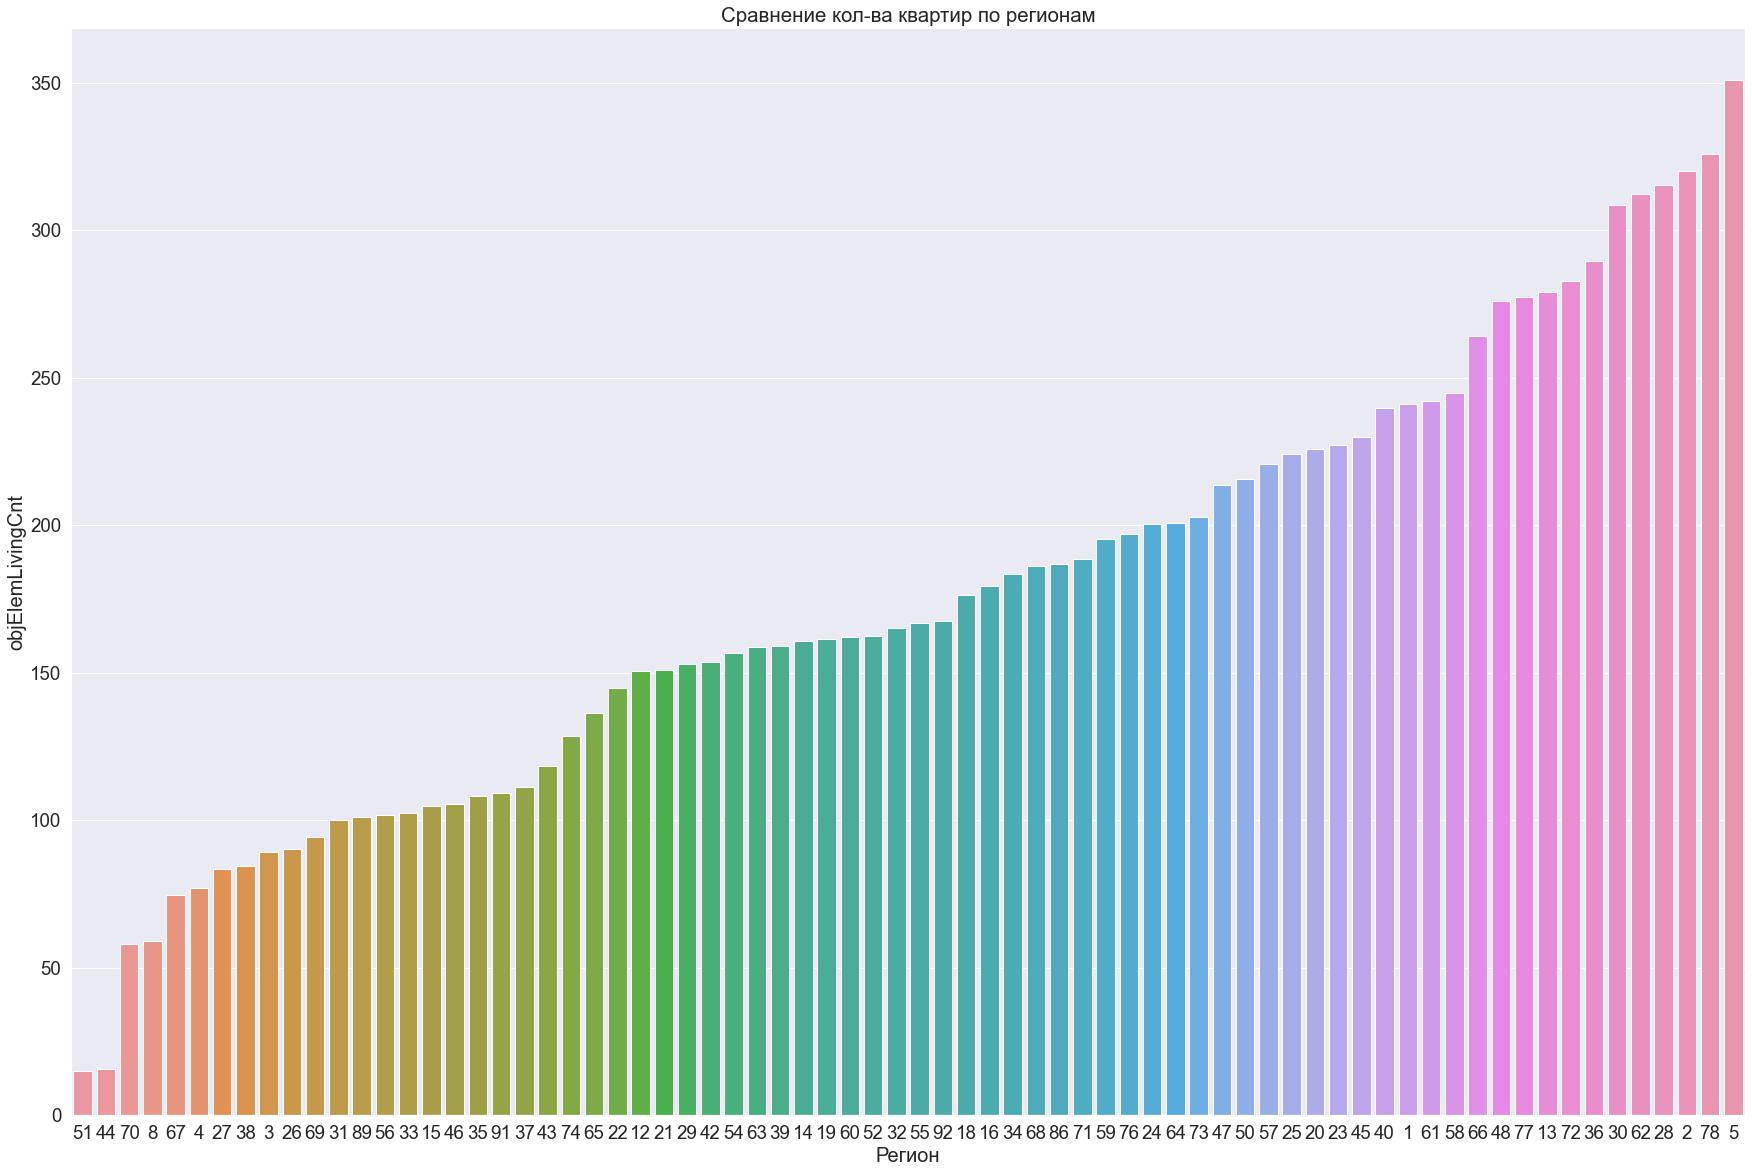

In [366]:
# Сравнение кол-ва квартир по регионам
avg_region_data = task.plot_index_per_square_by_region(detail_data, "objElemLivingCnt", "Сравнение кол-ва квартир по регионам")

objSquareLiving  region
region                         
51           865.100000      51
44           938.640000      44
4           3204.930000       4
67          3520.585000      67
27          4365.552264      27
...                 ...     ...
48         15968.060000      48
30         16678.446667      30
20         16887.630000      20
28         17100.100000      28
5          23833.596667       5

[72 rows x 2 columns]

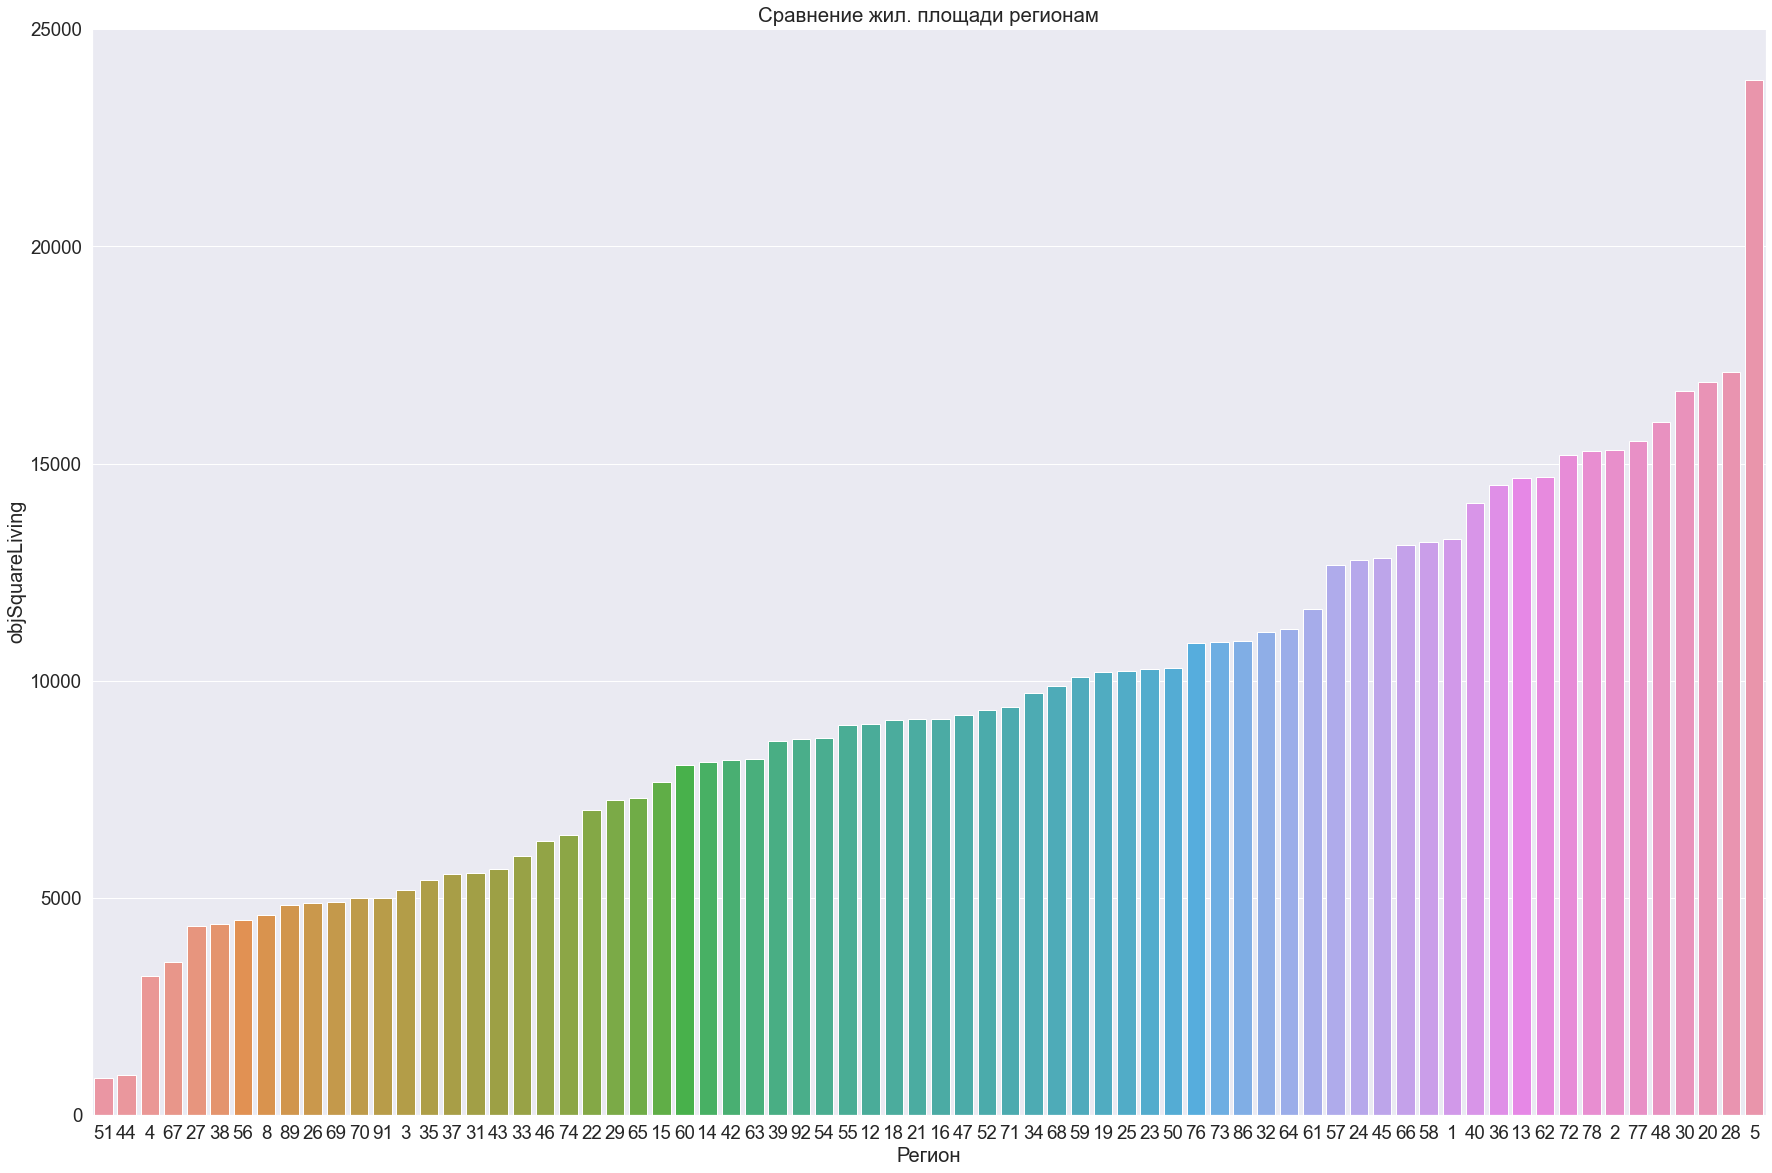

In [367]:
# Сравнение жил. площади регионам
task.plot_index_per_square_by_region(detail_data, "objSquareLiving", "Сравнение жил. площади регионам")

objElemParkingCnt  region
region                           
60               0.000000      60
32               0.000000      32
35               0.000000      35
37               0.000000      37
44               0.000000      44
...                   ...     ...
72              69.352941      72
25              74.550000      25
48              81.000000      48
34              85.333333      34
77             110.436066      77

[72 rows x 2 columns]

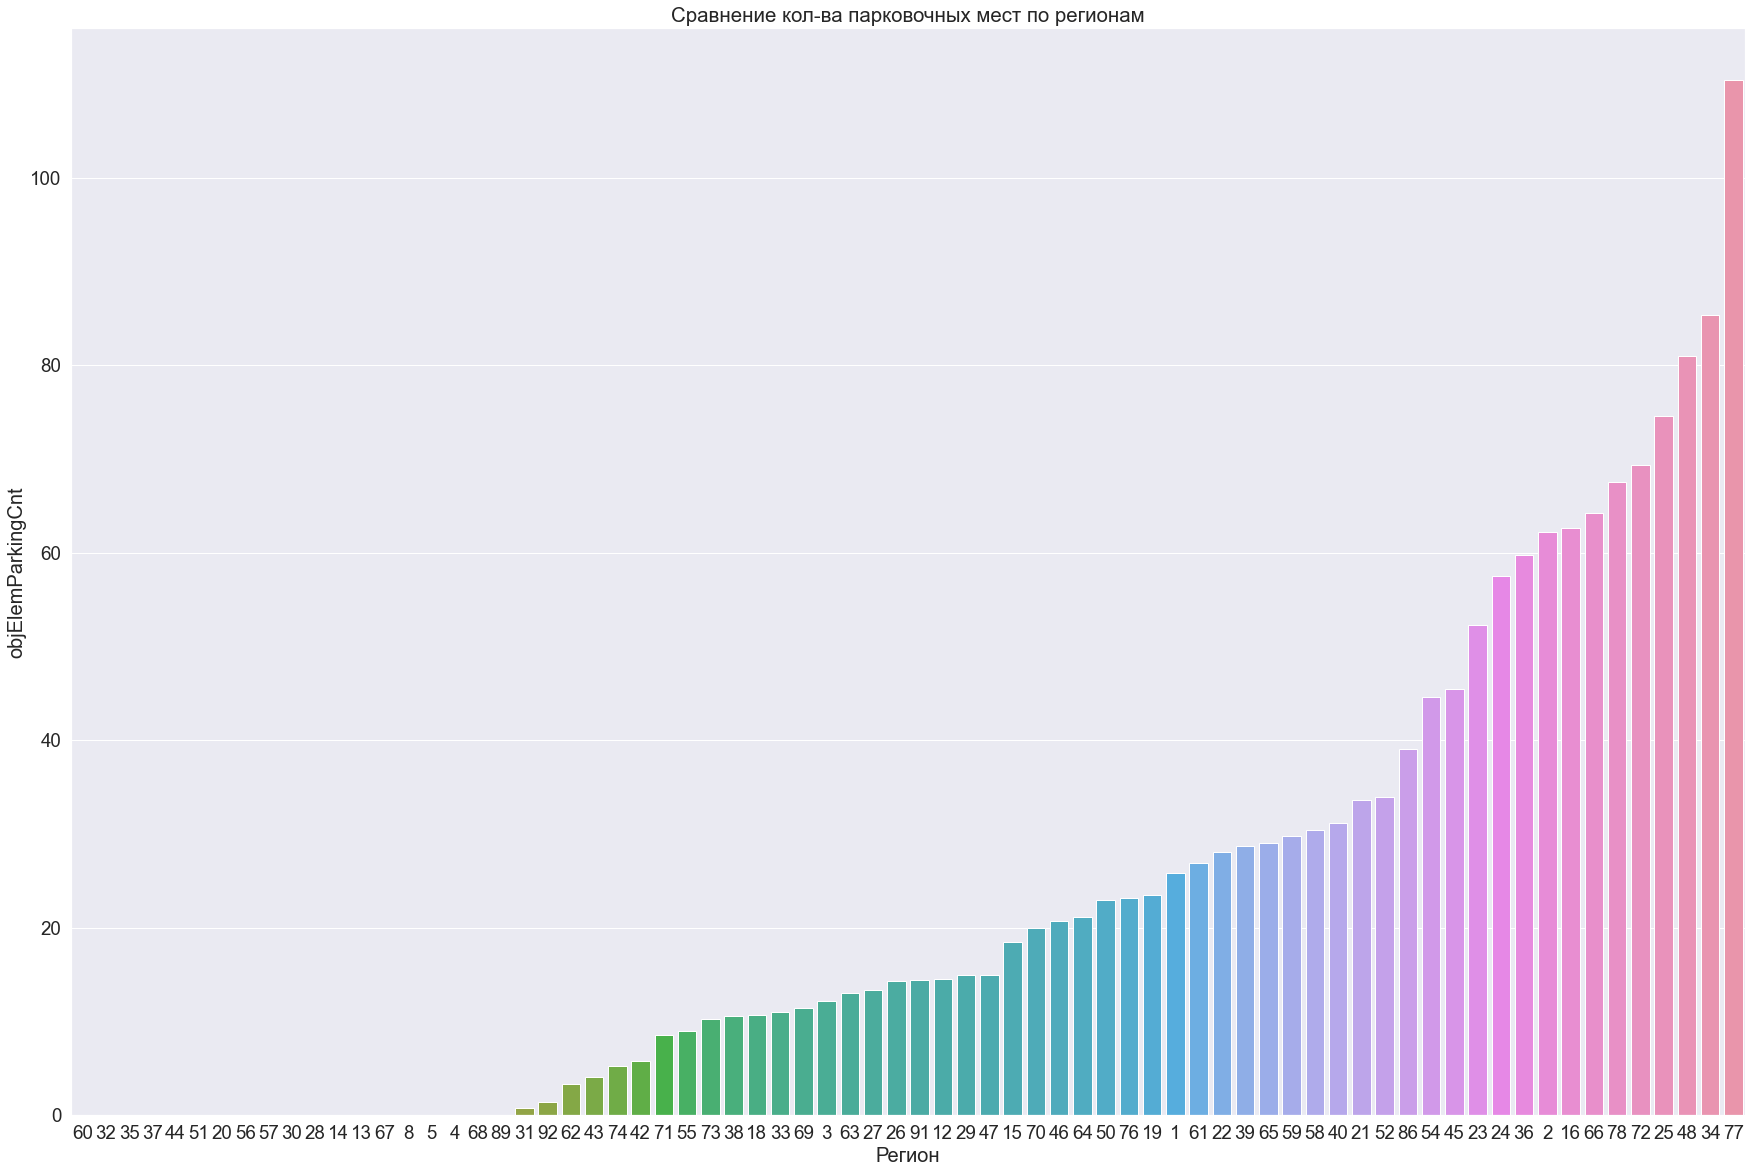

In [368]:
# Сравнение кол-ва парковочных мест по регионам
task.plot_index_per_square_by_region(detail_data, "objElemParkingCnt", "Сравнение кол-ва парковочных мест по регионам")

objPriceAvg  region
region                       
51       20442.000000      51
44       30104.800000      44
5        30621.666667       5
20       33273.000000      20
15       33784.000000      15
...               ...     ...
50      118748.634146      50
47      135425.206349      47
65      149913.000000      65
78      171837.445545      78
77      289776.140449      77

[72 rows x 2 columns]

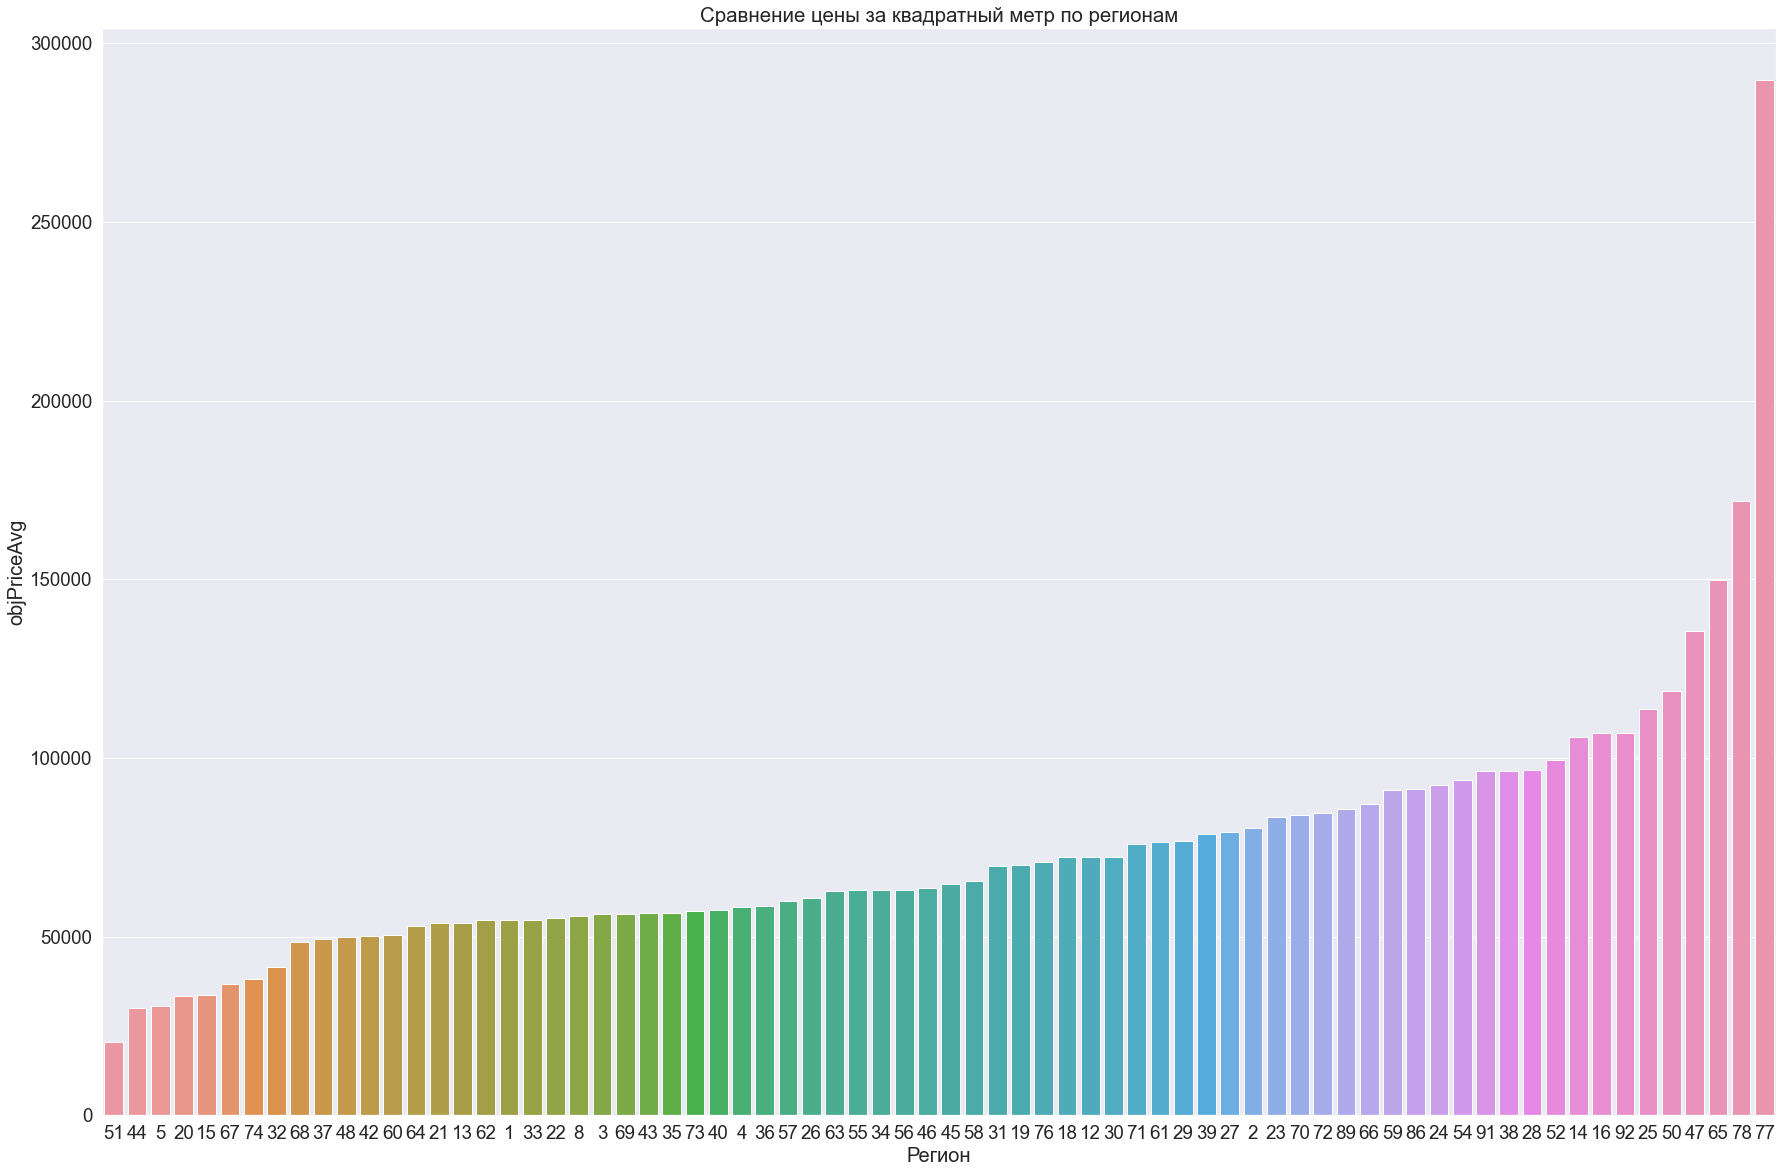

In [369]:
# Сравнение цены за квадратный метр по регионам
task.plot_index_per_square_by_region(detail_data, "objPriceAvg", "Сравнение цены за квадратный метр по регионам")

In [370]:
# Кол-во вводимого жилья по годам и регионыам
task.get_volume_commissioned_housing(detail_data)

objReady100PercDt 2017 2020 2021  2022  2023  2024 2025 2026 2027 2032
region                                                                
1                    -    -    -   1.0   2.0   1.0  1.0    -    -    -
2                    -    -    -  21.0  17.0  10.0  5.0  2.0  2.0    -
3                    -    -    -  10.0     -     -    -    -    -    -
4                    -    -    -     -   1.0     -    -    -    -    -
5                    -    -  1.0   1.0     -     -    -  1.0    -    -
...                ...  ...  ...   ...   ...   ...  ...  ...  ...  ...
78                   -    -    -  34.0  61.0  15.0  2.0    -    -    -
86                   -    -    -   8.0   1.0     -    -    -    -    -
89                   -  2.0  1.0   4.0     -     -    -    -    -    -
91                   -    -    -  14.0   8.0   5.0    -    -    -    -
92                   -    -  1.0   2.0     -     -  2.0    -    -    -

[72 rows x 10 columns]


objReady100PercDt 2017 2020 2021  2022  2023  2024 2025 2026 2027 2032
region                                                                
1                    -    -    -   1.0   2.0   1.0  1.0    -    -    -
2                    -    -    -  21.0  17.0  10.0  5.0  2.0  2.0    -
3                    -    -    -  10.0     -     -    -    -    -    -
4                    -    -    -     -   1.0     -    -    -    -    -
5                    -    -  1.0   1.0     -     -    -  1.0    -    -
...                ...  ...  ...   ...   ...   ...  ...  ...  ...  ...
78                   -    -    -  34.0  61.0  15.0  2.0    -    -    -
86                   -    -    -   8.0   1.0     -    -    -    -    -
89                   -  2.0  1.0   4.0     -     -    -    -    -    -
91                   -    -    -  14.0   8.0   5.0    -    -    -    -
92                   -    -  1.0   2.0     -     -  2.0    -    -    -

[72 rows x 10 columns]

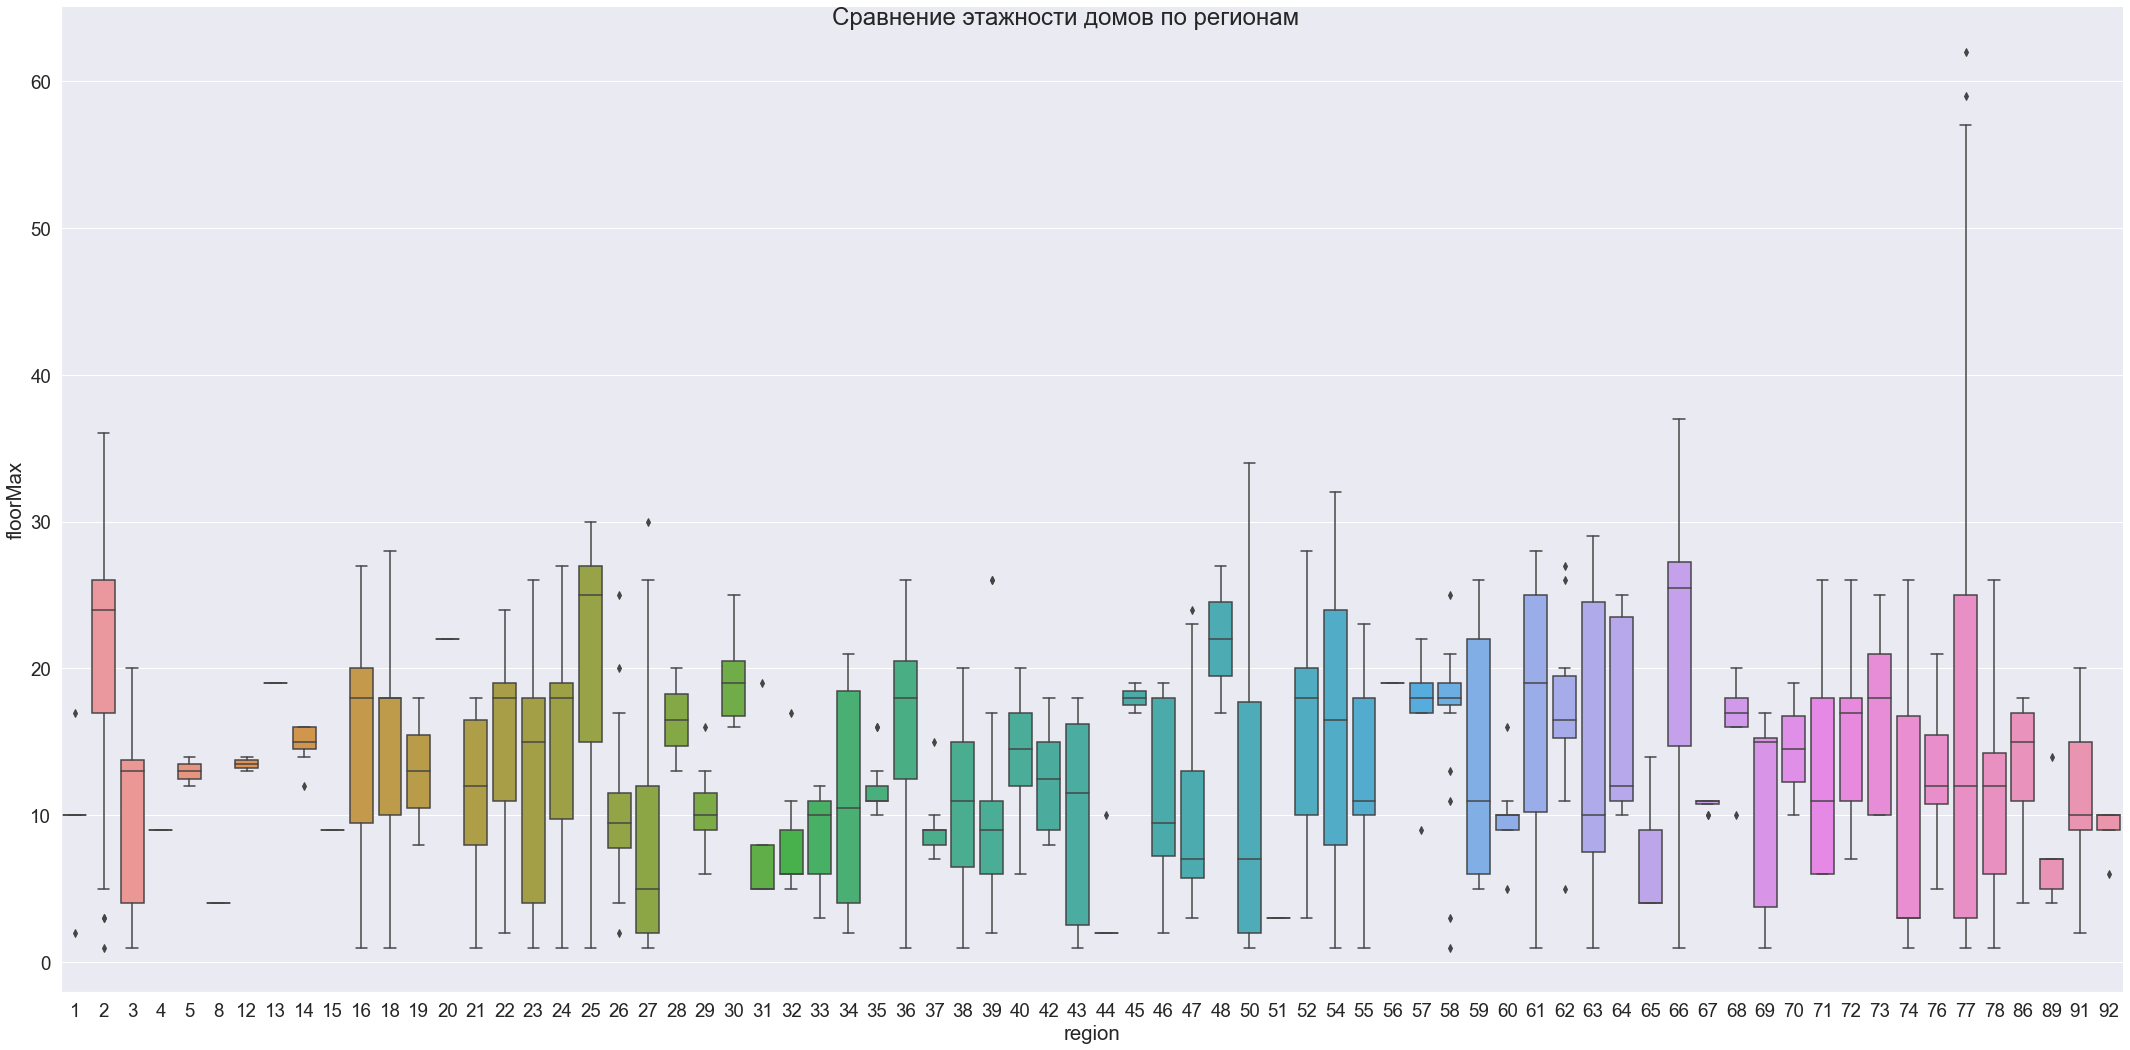

In [390]:
task.box_plot(detail_data, "floorMax", "Сравнение этажности домов по регионам")

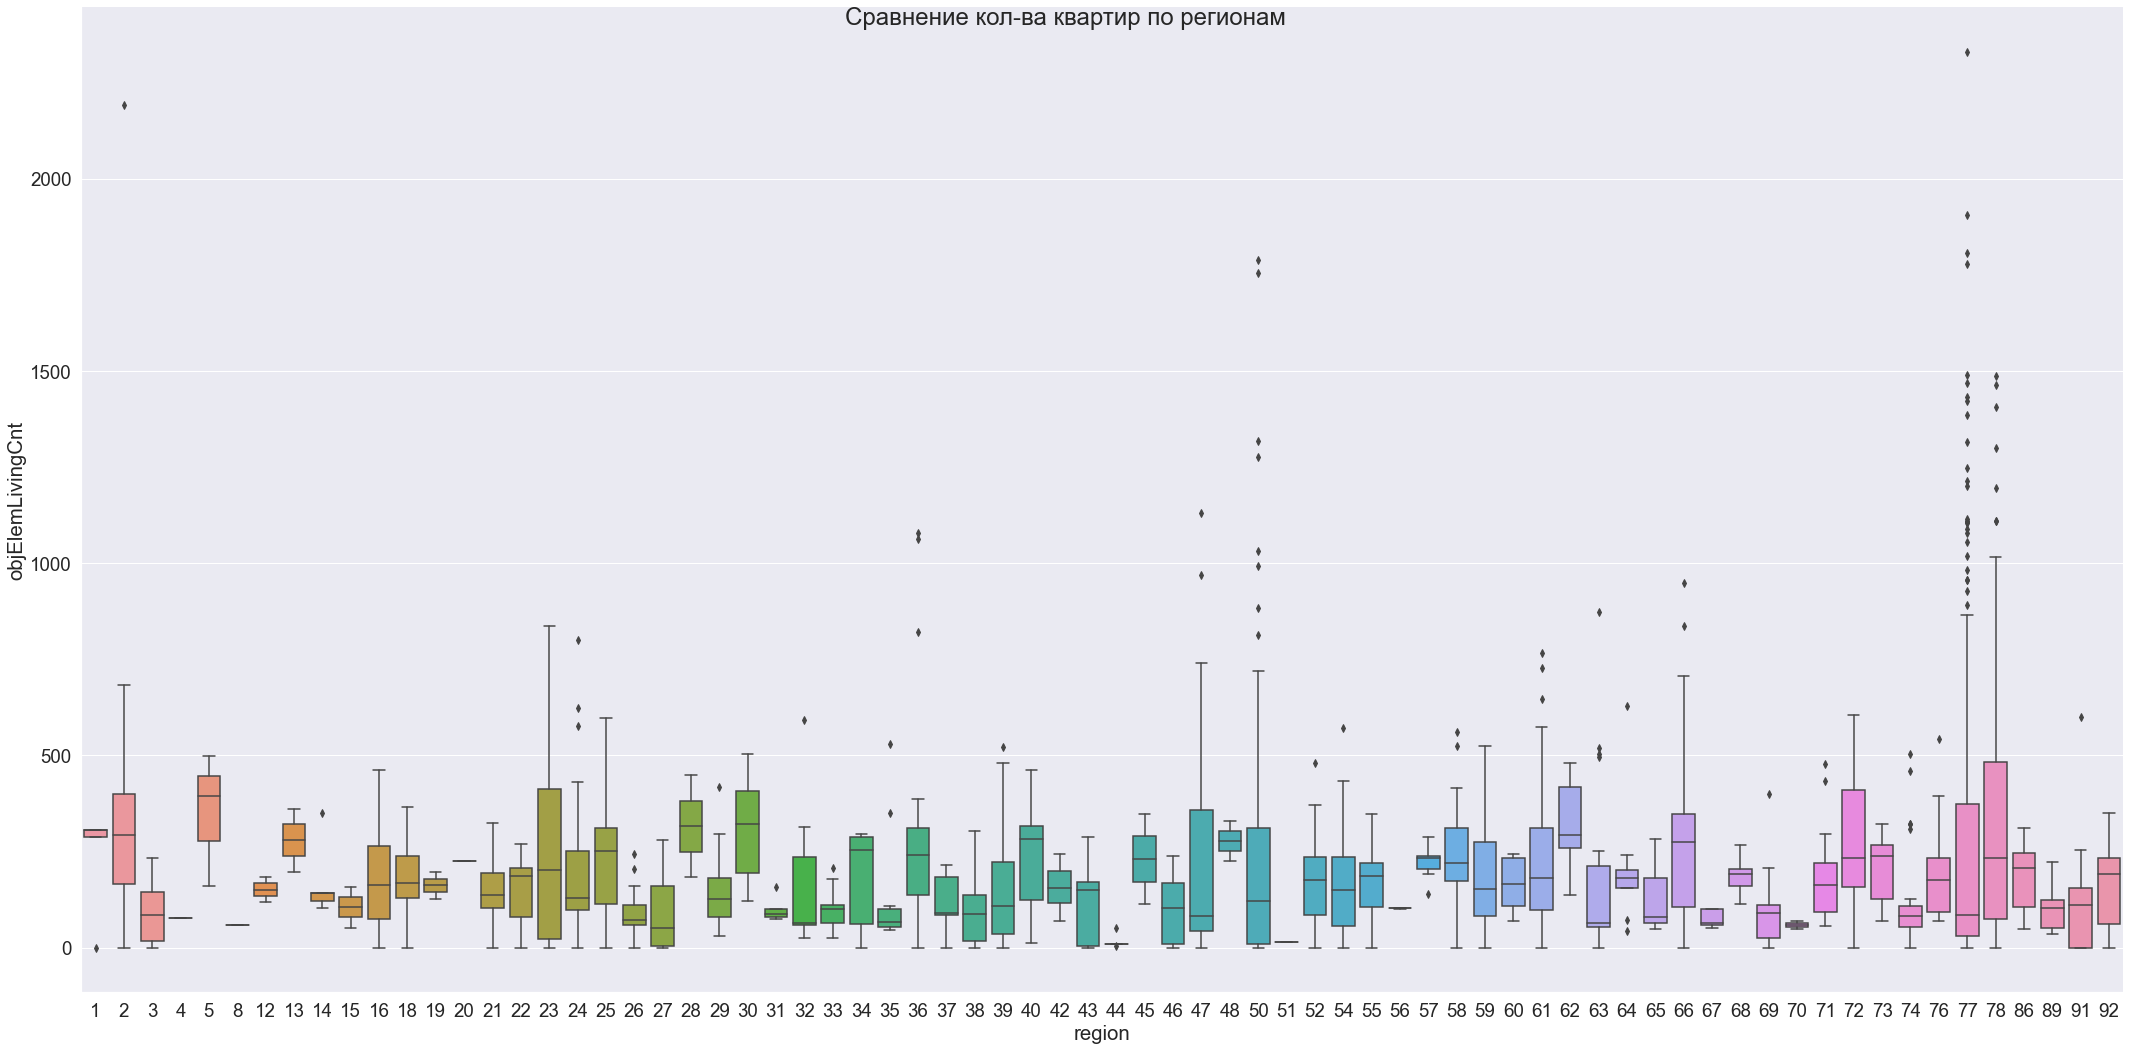

In [391]:
task.box_plot(detail_data, "objElemLivingCnt", "Сравнение кол-ва квартир по регионам")

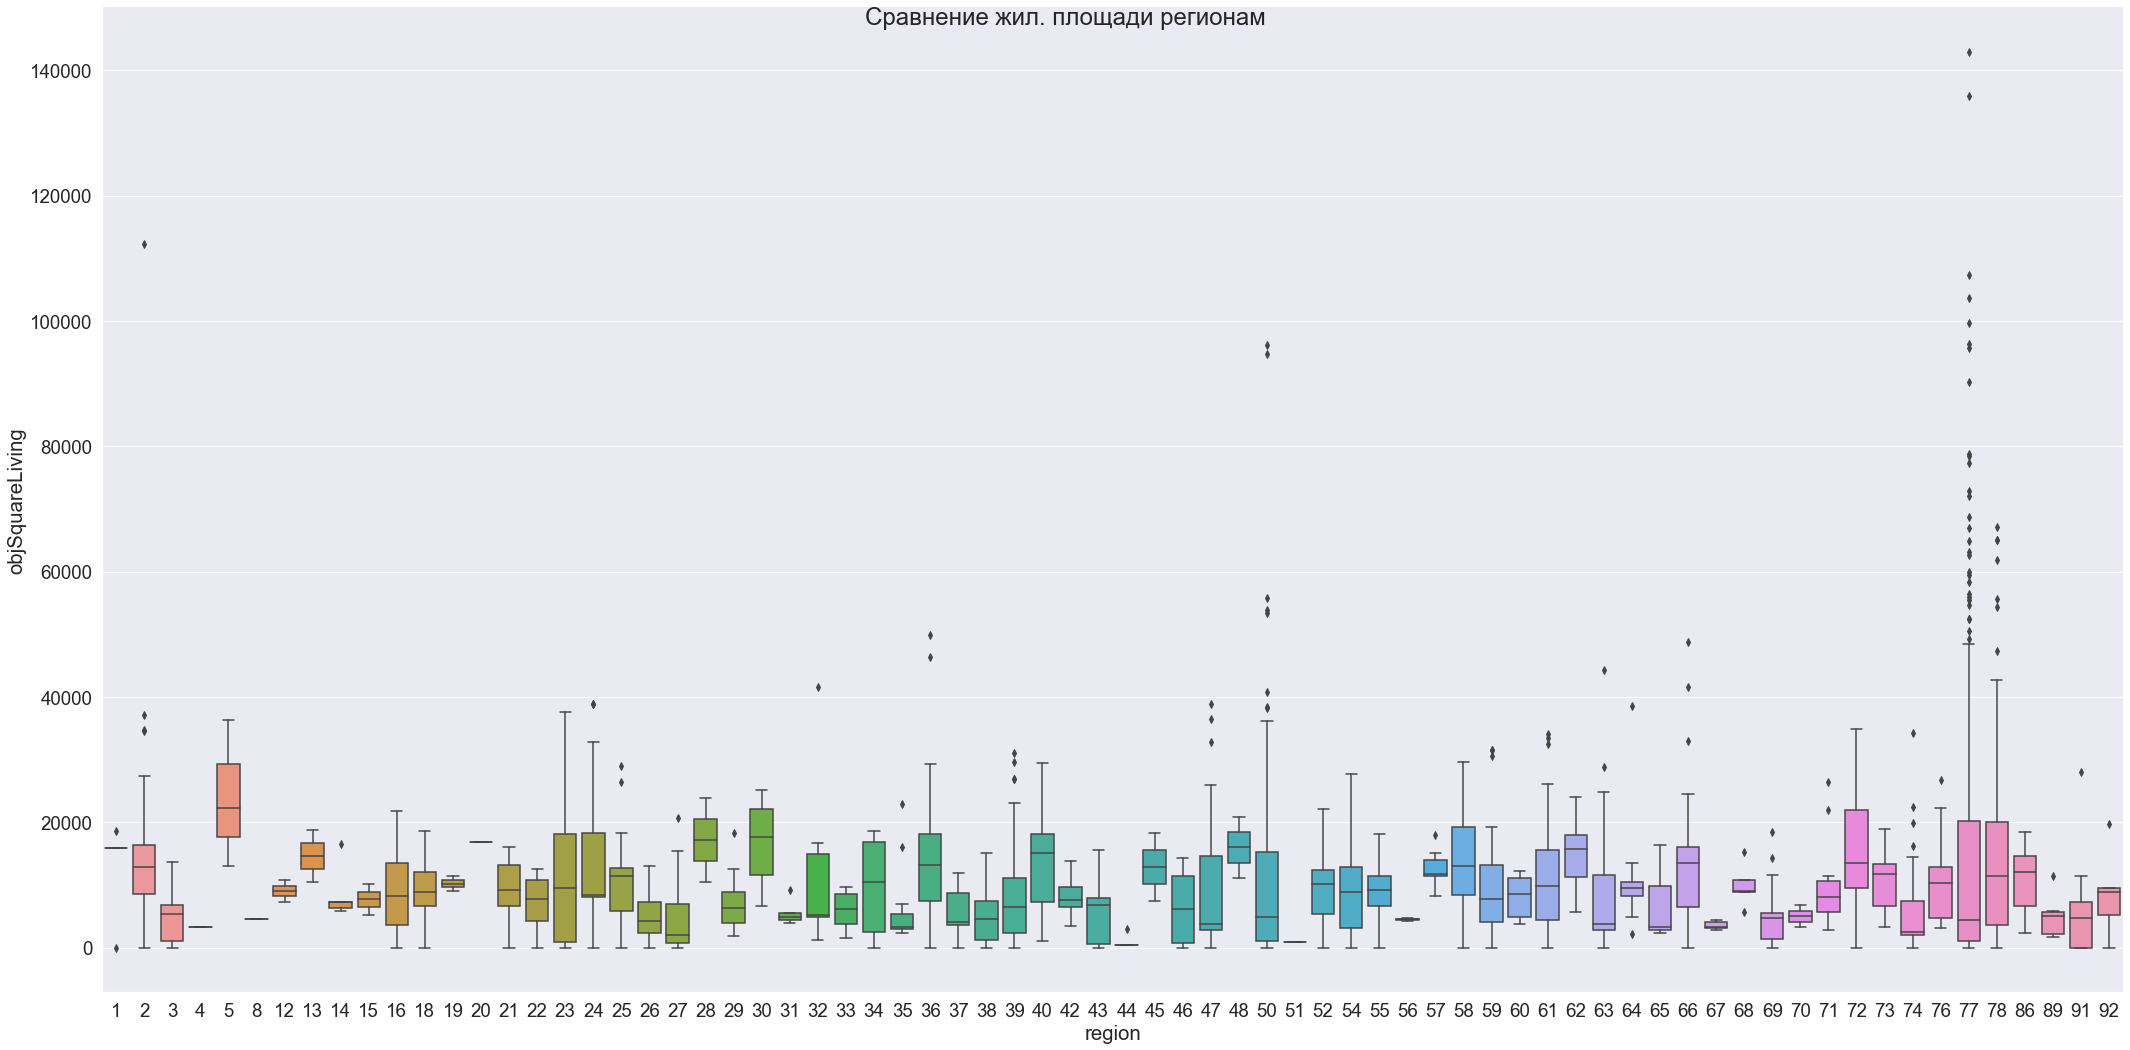

In [392]:
task.box_plot(detail_data, "objSquareLiving", "Сравнение жил. площади регионам")

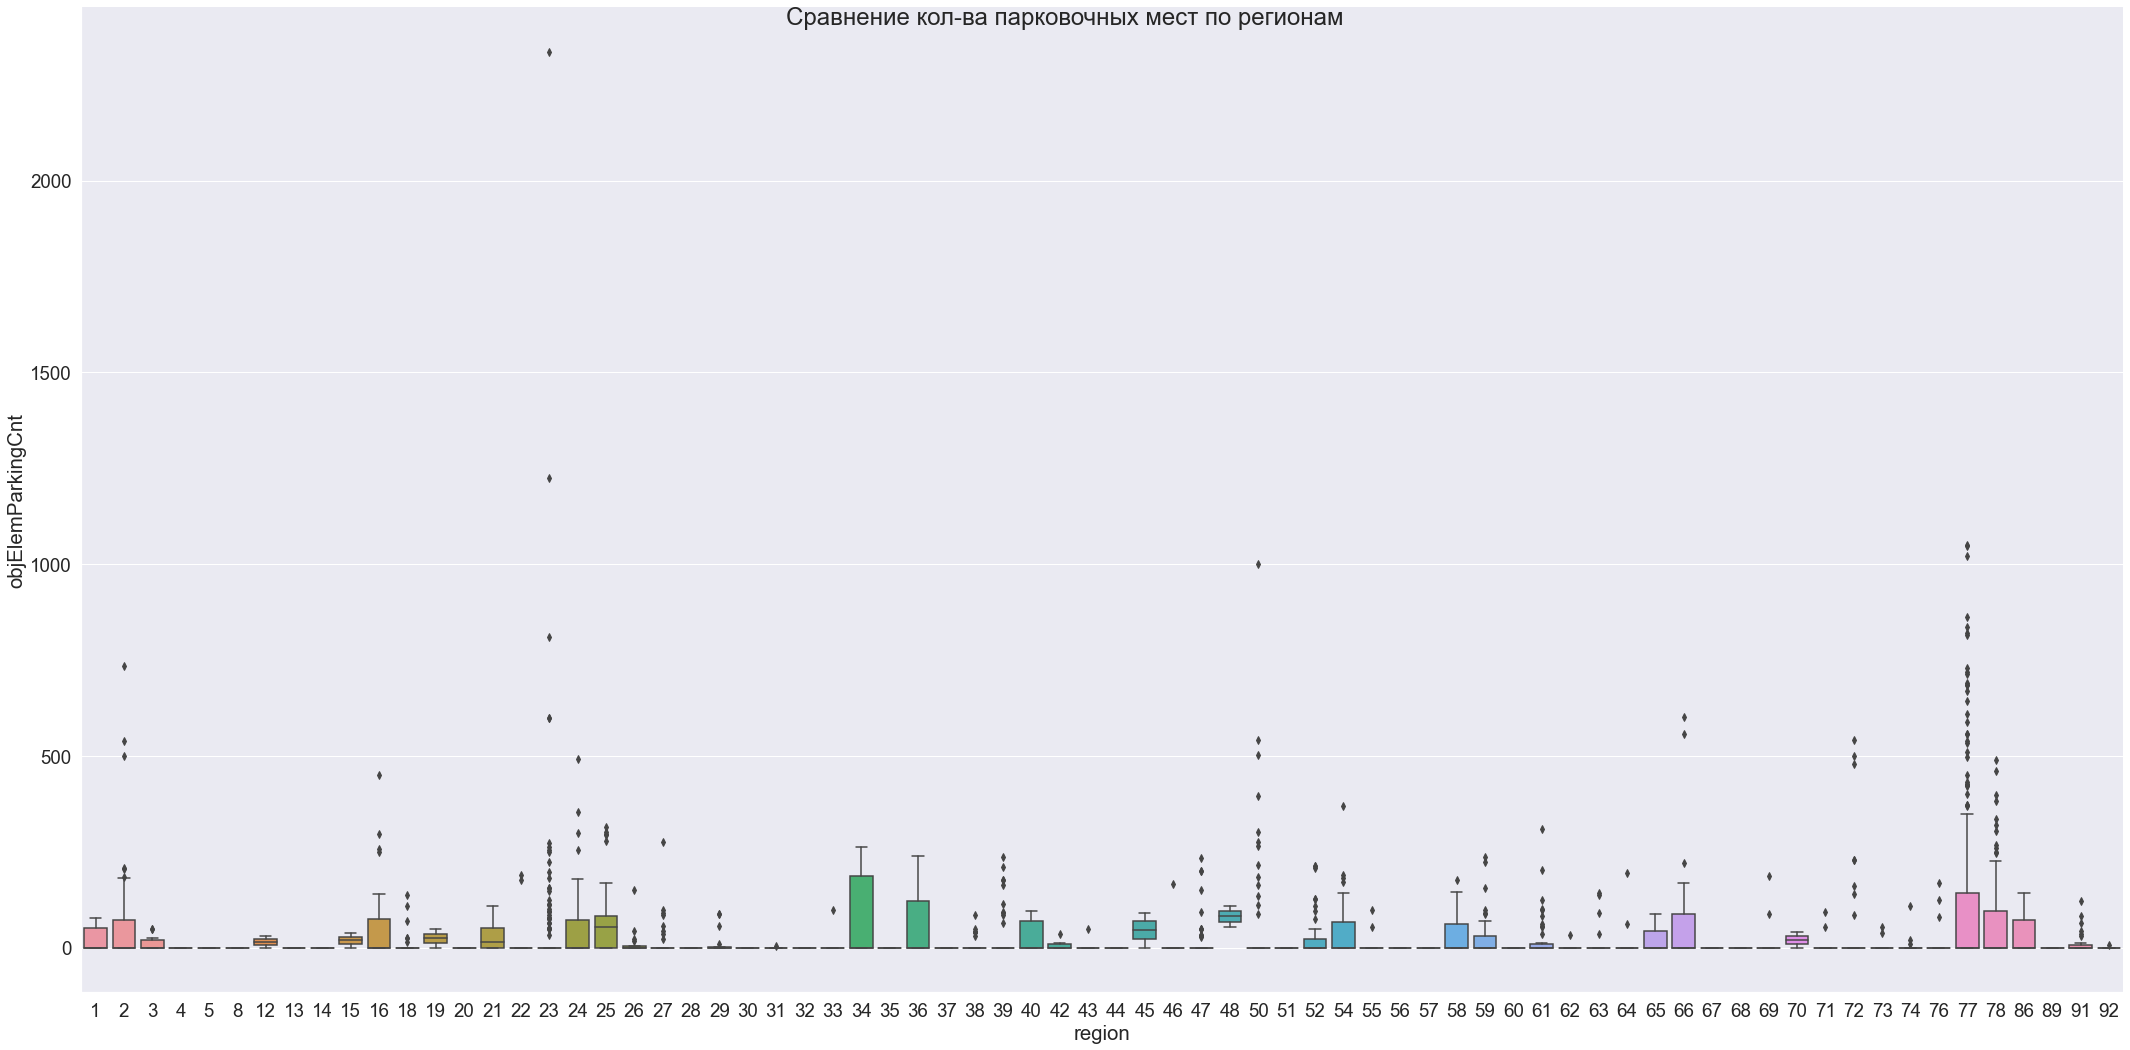

In [393]:
task.box_plot(detail_data, "objElemParkingCnt", "Сравнение кол-ва парковочных мест по регионам")

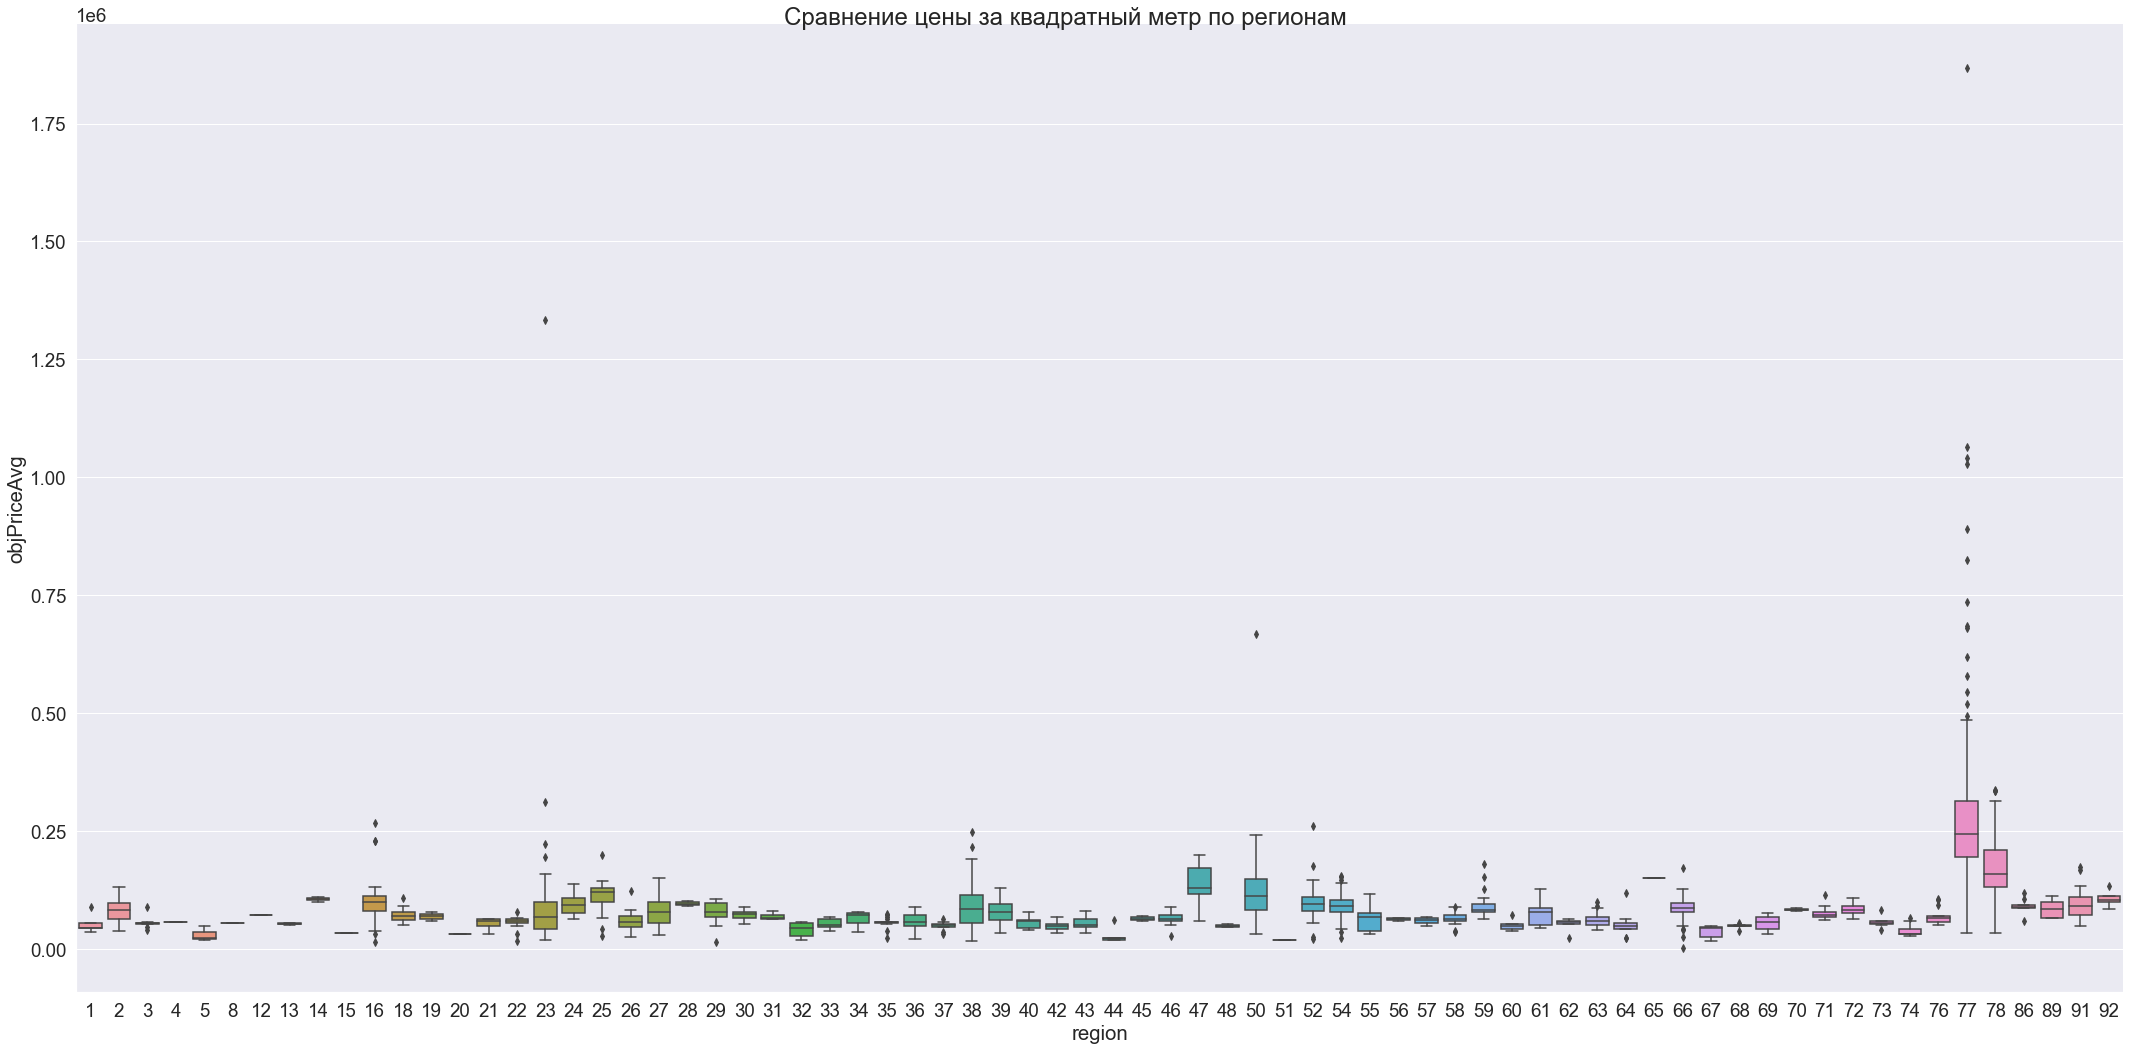

In [394]:
task.box_plot(detail_data, "objPriceAvg", "Сравнение цены за квадратный метр по регионам")

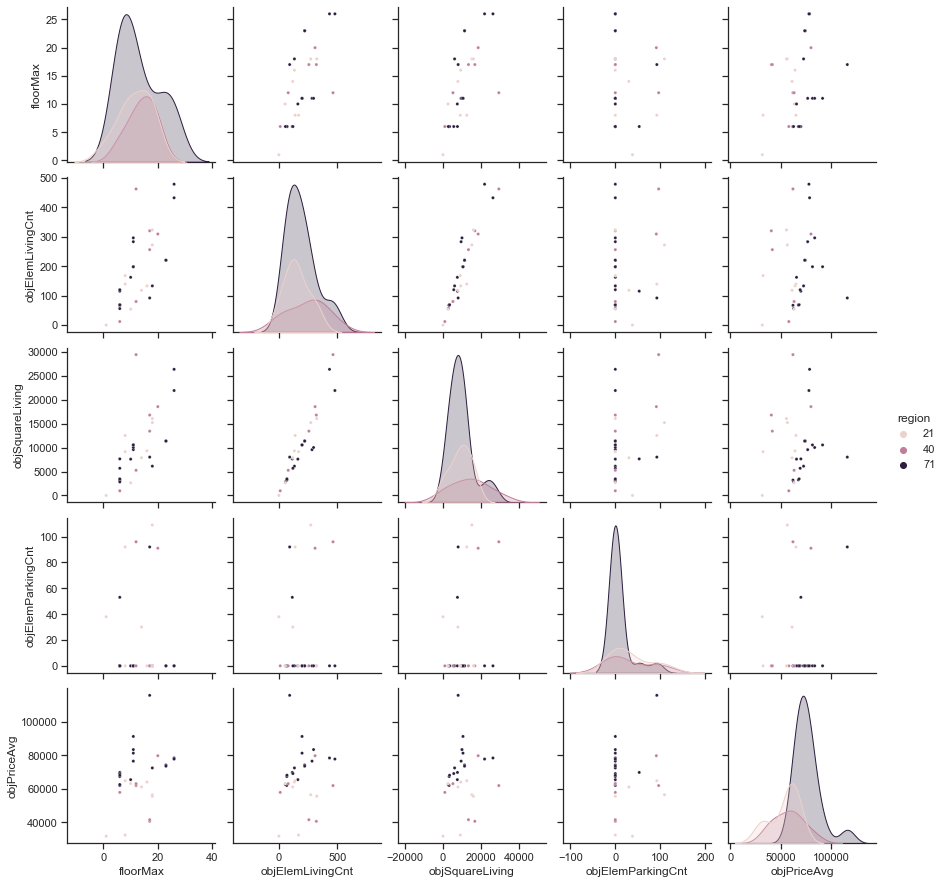

In [372]:
task.corr_plot(detail_data)